<a href="https://colab.research.google.com/github/marco-milanesi/social-project/blob/main/src/RL%20CartPole/DQL_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Deep Reinforcement Learning for the CartPole Environment


In [20]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np

import time

## Environment

The CartPole environment consists of a pole which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. The state space is represented by four values: cart position, cart velocity, pole angle, and the velocity of the tip of the pole. The action space consists of two actions: moving left or moving right. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

Source: [https://gym.openai.com/envs/CartPole-v1/](Open AI Gym). 

The cell below plots a bunch of example frames from the environment.

In [21]:
env = gym.envs.make("CartPole-v1")

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


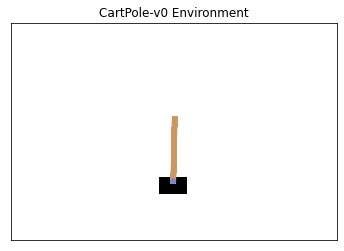

In [22]:
# Demonstration
env = gym.envs.make("CartPole-v1")


def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 2

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v0 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Plotting Function

This function will make it possible to analyze how the agent learns over time. The resulting plot consists of two subplots. The first one plots the total reward the agent accumulates over time, while the other plot shows a histogram of the agent's total rewards for the last 50 episodes. 

In [23]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## Random Search

Before implementing any deep learning approaches, I wrote a simple strategy where the action is sampled randomly from the action space. This approach will serve as a baseline for other strategies and will make it easier to understand how to work with the agent using the Open AI Gym environment.

In [24]:
def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
    return final

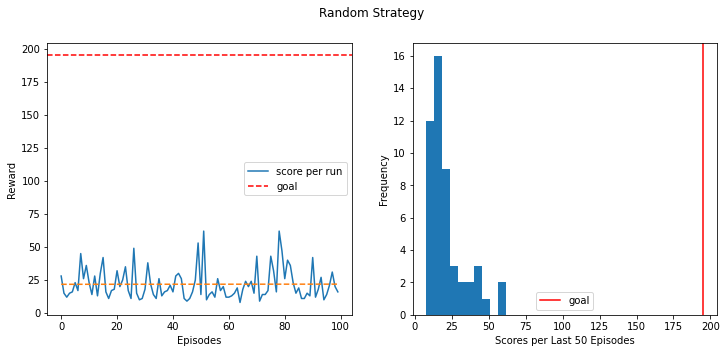

In [25]:
# Get random search results
episodes = 100
random_s = random_search(env, episodes)

The plot above presents the random strategy. As expected, it's impossible to solve the environment using this approach. The agent is not learning from their experience. Despite being lucky sometimes (getting a reward of almost 75), their average performance is as low as 10 steps.

## Deep Q Learning

The main idea behind Q-learning is that we have a function $Q: State \times Action \rightarrow \mathbb{R}$, which can tell the agent what actions will result in what rewards. If we know the value of Q, it is possible to construct a policy that maximizes rewards:

\begin{align}\pi(s) = \arg\!\max_a \ Q(s, a)\end{align}

However, in the real world, we don't have access to full information, that's why we need to come up with ways of approximating Q. One traditional method is creating a lookup table where the values of Q are updated after each of the agent's actions. However, this approach is slow and does not scale to large action and state spaces. Since neural networks are universal function approximators, I will train a network that can approximate $Q$.

The DQL class implementation consists of a simple neural network implemented in PyTorch that has two main methods--predict and update. The network takes the agent's state as an input and returns the Q values for each of the actions. The maximum Q value is selected by the agent to perform the next action.


In [26]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

The q_learning function is the main loop for all the algorithms that follow. 
It has many parameters, namely:

- Env represents the Open Ai Gym environment that we want to solve (CartPole.)
- Episodes stand for the number of games we want to play (from the beginning until the end.)
- Gamma is a discounting factor that is multiplied by future rewards to dampen these rewards' effect on the agent. It is designed to make future rewards worth less than immediate rewards.
- Epsilon represents the proportion of random actions relative to actions that are informed by existing "knowledge" that the agent accumulates during the episode. Before playing the game, the agent doesn't have any experience, so it is common to set epsilon to higher values and then gradually decrease its value.
- Eps_decay parameter indicates the speed at which the epsilon decreases as the agent learns. 0.99 comes from the original DQN paper.

I will explain other parameters later on when we will get to the corresponding agents.
The most straightforward agent updates its Q-values based on its most recent observation. It doesn't have any memory, but it learns by first exploring the environment and the gradually decreasing its epsilon value to make informed decisions:

In [27]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

### Parameters

In [28]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

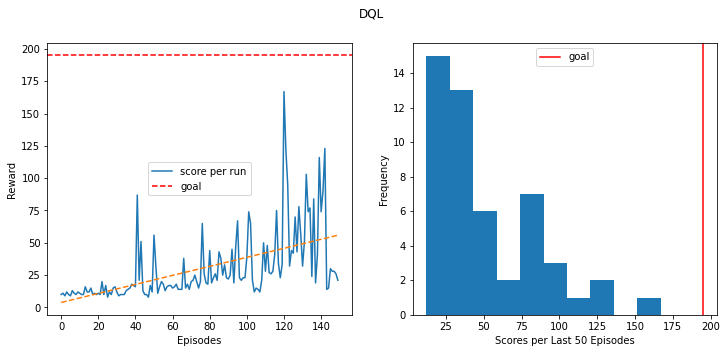

episode: 150, total reward: 21.0


In [29]:
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
simple = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.3)

The graph above shows that the performance of the agent has significantly improved. It got to 175 steps, which, as we've seen before, is impossible for a random agent. The trend line is also positive, and we can see that the performance increases over time. At the same time, the agent didn't manage to get above the goal line after 150 epochs, and its average performance is still around 15 steps, so there is definitely enough room for improvement.

## Replay

The approximation of Q using one sample at a time is not very effective. The graph above is a nice illustration of that. The network managed to achieve a much better performance compared to a random agent. However, it couldn't get to the threshold line of 195 steps. I implemented experience replay to improve network stability and make sure previous experiences are not discarded but used in training.

Experience replay stores the agent's experiences in memory. Batches of experiences are randomly sampled from memory and are used to train the neural network. Such learning consists of two phases--gaining experience and updating the model. The size of the replay controls the number of experiences that are used for the network update. Memory is an array that stores the agent's state, reward, and action, as well as whether the action finished the game and the next state.

In [30]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    #old replay function
    #def replay(self, memory, size, gamma=0.9):
        #""" Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        #if len(memory) >= size:
            #states = []
            #targets = []
            # Sample a batch of experiences from the agent's memory
            #batch = random.sample(memory, size)
            
            # Extract information from the data
            #for state, action, next_state, reward, done in batch:
                #states.append(state)
                # Predict q_values
                #q_values = self.predict(state).tolist()
                #if done:
                    #q_values[action] = reward
                #else:
                    #q_values_next = self.predict(next_state)
                    #q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
                #targets.append(q_values)

            #self.update(states, targets)
    
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

### replay using old replay function

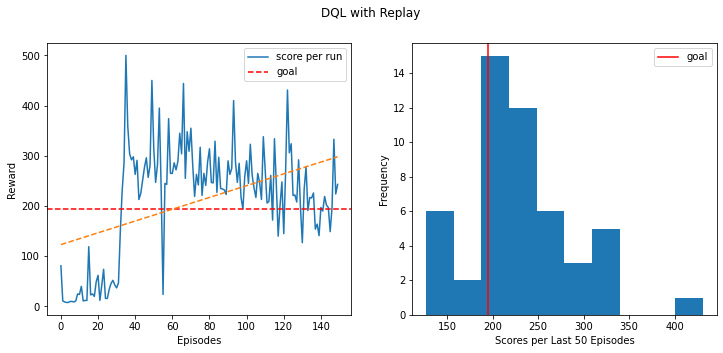

episode: 150, total reward: 243.0
Average replay time: 0.3300170373916626


In [31]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

### replay using new replay function

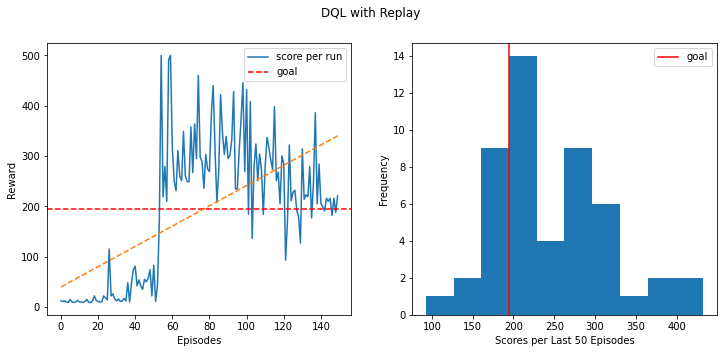

episode: 150, total reward: 221.0
Average replay time: 0.2961651102701823


In [32]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

As expected, the neural network with the replay seems to be much more robust and smart compared to its counterpart that only remembers the last action. After approximately 60 episodes, the agent managed to achieve the winning threshold and remain at this level. I also managed to achieve the highest reward possible--500.

## Double Q Learning

Traditional Deep Q Learning tends to overestimate the reward, which leads to unstable training and lower quality policy. Let's consider the equation for the Q value:
The last part of the equation takes the estimate of the maximum value. This procedure results in systematic overestimation, which introduces a maximization bias. Since Q-learning involves learning estimates from estimates, such overestimation is especially worrying.

To avoid such a situation, I will define a new target network. The Q values will be taken from this new network, which is meant to reflect the state of the main DQN. However, it doesn't have identical weights because it's only updated after a certain number of episodes. This idea has been first introduced in Hasselt et al., 2015.
The addition of the target network might slow down the training since the target network is not continuously updated. However, it should have a more robust performance over time.

n_update parameter specifies the interval, after which the target network should be updated.

In [33]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

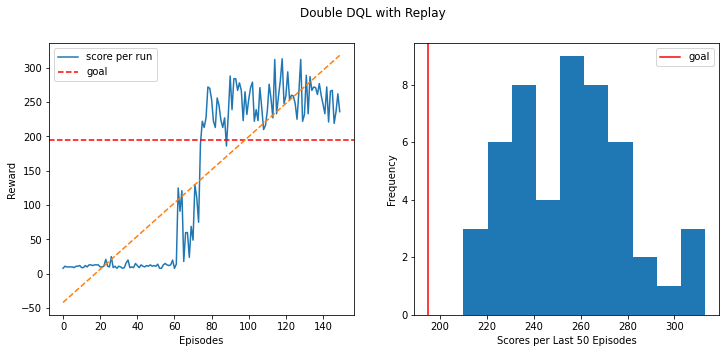

episode: 150, total reward: 236.0
Average replay time: 0.6248194630940755


In [34]:
# Get replay results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)


Double DQL with replay has outperformed the previous version and has consistently performed above 300 steps. The performance also seems to be a bit more stable, thanks to the separation of action selection and evaluation. Finally, let's explore the last modification to the DQL agent.

The network with soft target updates performed quite well. However, it doesn't seem to be better than hard weight updates after a certain number of steps. 

## Conclusion

The implementation of the experience replay and the target network have significantly improved the performance of a Deep Q Learning agent in the Open AI CartPole environment. Some other modifications to the agent, such as Dueling Network Architectures (Wang et al., 2015), can be added to this implementation to improve the agent's performance. The algorithm is also generalizable to other environments. Thus, it's possible to test how well it performs on other tasks. 

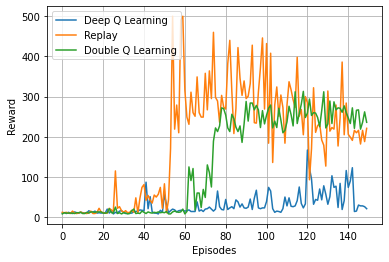

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(simple, label='Deep Q Learning')
plt.plot(replay, label='Replay')
plt.plot(double, label='Double Q Learning')
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()
plt.savefig('CartPole_RL.pdf', format='pdf')
